<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA 
</center></font>


<center><h2>Proyecto 1</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: José Alvarado Espinoza</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>
 

In [4]:
from IPython.display import IFrame, display
filepath = "Proyecto_1_EIE401.pdf"
IFrame(filepath, width=700, height=400)

Debes usar el sitio https://gwosc.org/eventapi/html/GWTC/, donde encuentras todo el catálogo de observaciones con los datos en diferentes formatos. Debes seleccionar una detección para tu estudio y descargar los datos correspondientes (H5 o TXT), lo que posteriormente deberás tratar de manera digital como audio (serie de tiempo).
tip: Te recomiendo tomar la serie de tiempo corta (32 segundos) para facilitar el análisis, y asegurarte de tomar la tasa de muestreo más alta.
tip: Asegúrate de tomar un caso cuyo espectrograma de muestra, indique una señal clara y fuerte para facilitar tu trabajo, de otra forma es posible que no logres aislarla lo suficiente.


## 1. Carga de Datos


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from urllib.request import urlopen
from scipy.io import wavfile

Cantidad de datos: 524288
Primeros 5 datos: [ 6.09513456e-21  1.48369999e-20  2.28723129e-20 -6.86709683e-21
  2.40735447e-20]


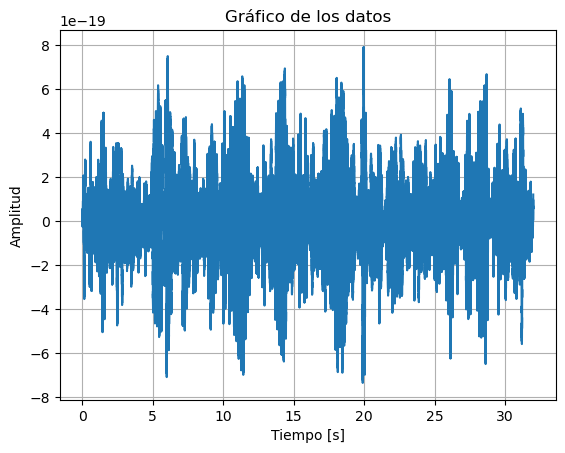

In [9]:

# URL de los datos
url_datos = "https://raw.githubusercontent.com/kationj/EIE-401JEAE_Actividades/main/Proyecto_1/H-H1_GWOSC_16KHZ_R1-1126259447-32.txt"

# Cargar los datos directamente desde la URL
datos_txt = np.genfromtxt(urlopen(url_datos), skip_header=3)

# Verificar la cantidad de datos y mostrar los primeros datos
print("Cantidad de datos:", datos_txt.size)
print("Primeros 5 datos:", datos_txt[:5])

# Crear el array de tiempo, asumiendo una duración total de 32 segundos
t = np.linspace(0, 32, datos_txt.size)

# Graficar los datos
plt.plot(t, datos_txt)
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Gráfico de los datos')
plt.grid()
plt.show()

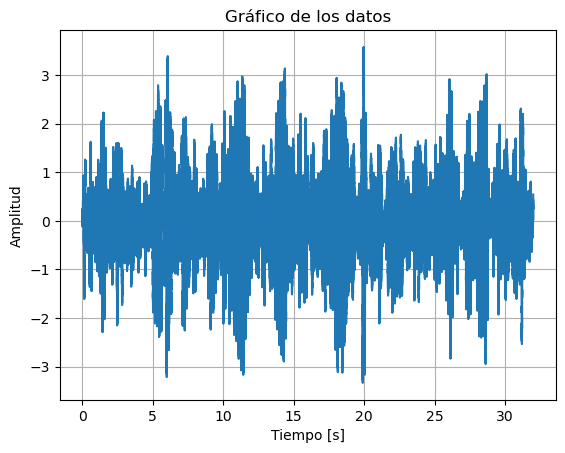

In [10]:
# Normalizamos los datos
datos_txt_norm = (datos_txt - np.mean(datos_txt)) / np.std(datos_txt)

t = np.linspace(0, 32, datos_txt_norm.size)

# Graficar los datos
plt.plot(t, datos_txt_norm)
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Gráfico de los datos')
plt.grid()
plt.show()

## 2. Convertir en audio
Es una forma de validar que tenemos un alto componente de ruido en la señal y que el interés es eliminarlo para encontrar una señal candidata.

Te recomiendo hacer una señal de audio de cada uno de las etapas para así validar como va el proceso. Al final deberás obtener un señal con CHIRP o BUMP. Son sonidos que comprueban que tienes una cantidad de potencia que sobre destaca sobre el ruido.

In [12]:
#Frecuencia de muestreo en Hz
fs = 16384

# Guardamos la señal en un archivo de audio WAV
nombre_archivo = "señal_prueba.wav"
wavfile.write(nombre_archivo, fs, datos_txt_norm.astype(np.float32))
print(f"La señal se ha guardado como '{nombre_archivo}'")



La señal se ha guardado como 'señal_prueba.wav'


## 3. Análisis de Fourier
Al realizar la conversión, queremos ver cuales son las componentes de ruido que más afectan al instrumento y debemos ignorar en el análisis. Eso se ve como "pico" o la apariencia de "peine".
Se debe presenta la densidad espectral de potencia antes y después de la función de Windowing.


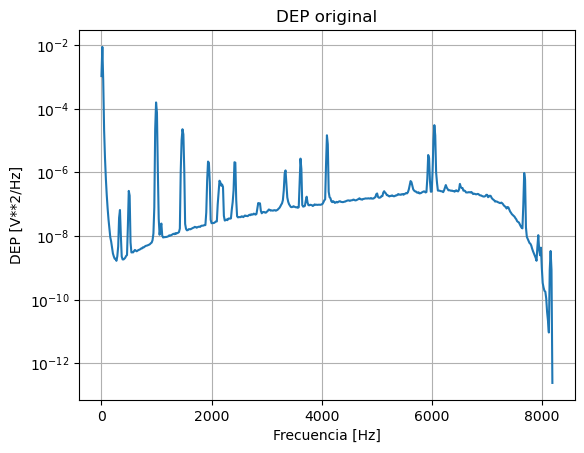

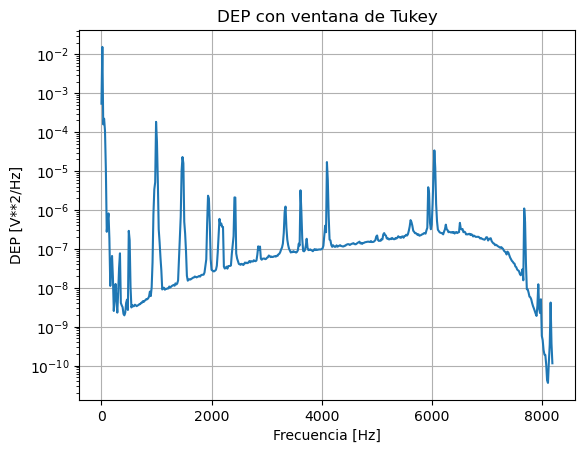

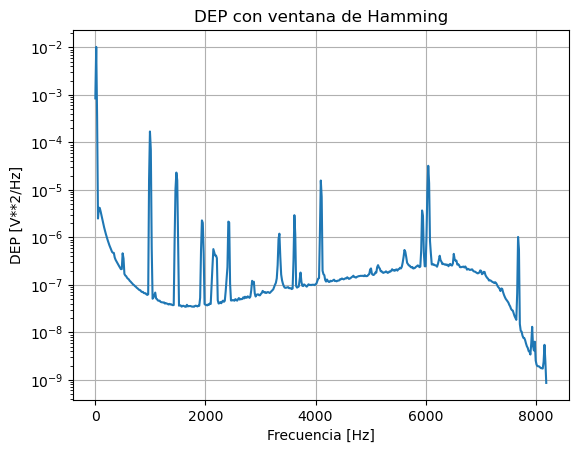

In [14]:
from scipy.signal import welch, windows

# Calculamos la DEP original 
f, DEP = welch(datos_txt_norm, fs, nperseg=1024)
plt.semilogy(f, DEP)
plt.title('DEP original')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('DEP [V**2/Hz]')
plt.grid()
plt.show()

# Aplicamos la ventana de Tukey
window = windows.tukey(1024)
f_tukey, DEP_tukey = welch(datos_txt_norm, fs, nperseg=1024, window=window)
plt.semilogy(f_tukey, DEP_tukey)
plt.title('DEP con ventana de Tukey')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('DEP [V**2/Hz]')
plt.grid()
plt.show()

# Aplicamos la ventana de Hamming
window = windows.hamming(1024)
f_ham, DEP_ham = welch(datos_txt_norm, fs, nperseg=1024, window=window)
plt.semilogy(f_ham, DEP_ham)
plt.title('DEP con ventana de Hamming')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('DEP [V**2/Hz]')
plt.grid()
plt.show()


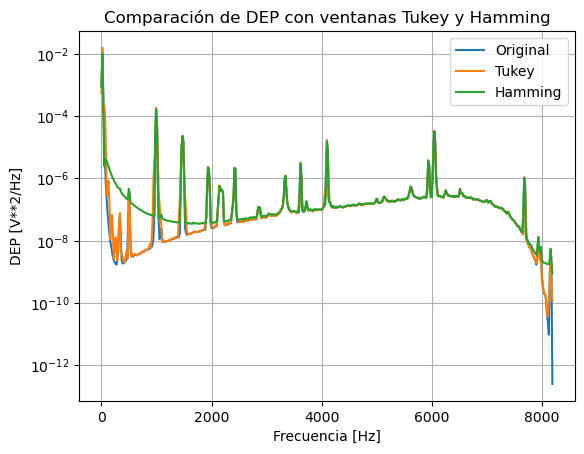

In [15]:
from scipy.signal import welch, windows
import numpy as np
import matplotlib.pyplot as plt

# Frecuencia de muestreo en Hz
fs = 16384

# Calcular la densidad espectral de potencia (DEP) original
f_orig, DEP_orig = welch(datos_txt_norm, fs, nperseg=1024)
plt.semilogy(f_orig, DEP_orig, label='Original')

# Aplicar la ventana de Tukey
window_tukey = windows.tukey(1024)
f_tukey, DEP_tukey = welch(datos_txt_norm, fs, nperseg=1024, window=window_tukey)
plt.semilogy(f_tukey, DEP_tukey, label='Tukey')

# Aplicar la ventana de Hamming
window_hamming = windows.hamming(1024)
f_hamming, DEP_hamming = welch(datos_txt_norm, fs, nperseg=1024, window=window_hamming)
plt.semilogy(f_hamming, DEP_hamming, label='Hamming')

# Ajustar la DEP para mantener la energía después de aplicar la ventana
DEP_tukey_adjusted = DEP_tukey * np.mean(window_tukey ** 2)
DEP_hamming_adjusted = DEP_hamming * np.mean(window_hamming ** 2)

# Graficar los resultados
plt.title('Comparación de DEP con ventanas Tukey y Hamming')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('DEP [V**2/Hz]')
plt.legend()
plt.grid()
plt.show()

## 4. Procesamiento 
Debes inferir de tu estudio, cual es el proceso que aplican a la señal y reproducirlo. Es posible que cada estudiante llegue a una solución más o menos diferente, pues no hay un código abierto donde esté el procedimiento completo.


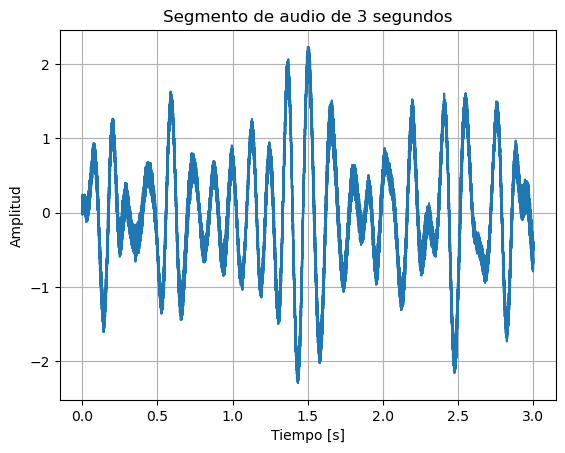

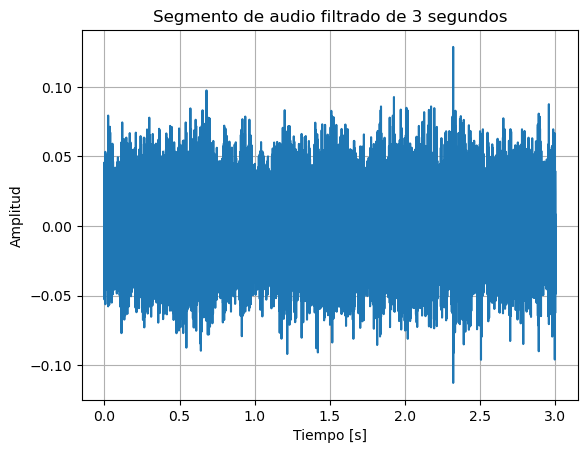

In [17]:
# Extraer un segmento de 3 segundos del audio
duracion_segmento = 3  # Duración del segmento en segundos
muestras_segmento = duracion_segmento * fs  # Número de muestras en el segmento

# Seleccionar las primeras muestras del audio para el segmento
segmento_audio = datos_txt_norm[:muestras_segmento]

# Graficar el segmento de audio
t_segmento = np.linspace(0, duracion_segmento, muestras_segmento)
plt.plot(t_segmento, segmento_audio)
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Segmento de audio de 3 segundos')
plt.grid()
plt.show()

# Aplicar el filtro pasa banda al segmento de audio
from scipy.signal import butter, filtfilt

# Definir frecuencias de corte del filtro
lowcut = 1500  # Frecuencia de corte inferior (Hz)
highcut = 4200  # Frecuencia de corte superior (Hz)

# Diseñar el filtro pasa banda
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
order = 5 # Orden del filtro
b, a = butter(order, [low, high], btype='band')

# Aplicar el filtro al segmento de audio
segmento_filtrado = filtfilt(b, a, segmento_audio)

# Graficar el segmento de audio filtrado
plt.plot(t_segmento, segmento_filtrado)
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Segmento de audio filtrado de 3 segundos')
plt.grid()
plt.show()

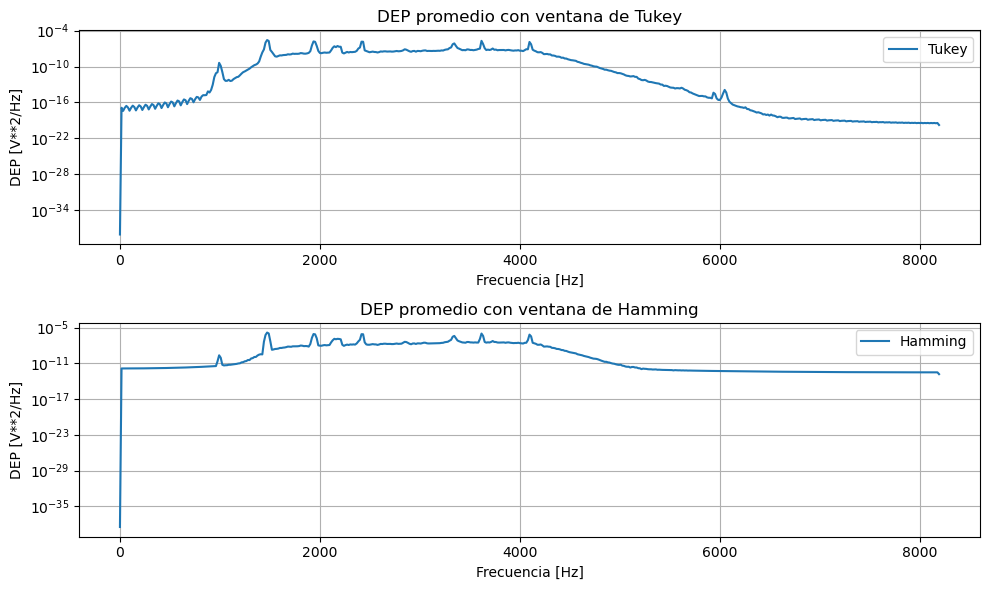

El segmento de audio filtrado se ha guardado como 'segmento_audio_filtrado.wav'


In [18]:
from scipy.signal import welch, windows
import numpy as np
import matplotlib.pyplot as plt

# Definir la longitud de la ventana para el análisis espectral
longitud_ventana = 1024

# Definir el paso de avance para la aplicación de la ventana
paso_avance = longitud_ventana // 2

# Inicializar listas para almacenar los segmentos de audio filtrado con ventana
segmentos_tukey = []
segmentos_hamming = []

# Aplicar la ventana de Tukey y Hamming a segmentos superpuestos del audio filtrado
indice_inicio = 0
while indice_inicio + longitud_ventana <= len(segmento_filtrado):
    # Seleccionar el segmento de audio filtrado para aplicar la ventana
    segmento_actual = segmento_filtrado[indice_inicio:indice_inicio + longitud_ventana]
    
    # Aplicar la ventana de Tukey al segmento de audio filtrado
    window_tukey = windows.tukey(longitud_ventana)
    segmento_tukey = segmento_actual * window_tukey
    
    # Aplicar la ventana de Hamming al segmento de audio filtrado
    window_hamming = windows.hamming(longitud_ventana)
    segmento_hamming = segmento_actual * window_hamming
    
    # Agregar los segmentos con ventana a las listas
    segmentos_tukey.append(segmento_tukey)
    segmentos_hamming.append(segmento_hamming)
    
    # Avanzar al siguiente segmento
    indice_inicio += paso_avance

# Convertir las listas de segmentos con ventana a arrays
segmentos_tukey = np.array(segmentos_tukey)
segmentos_hamming = np.array(segmentos_hamming)

# Calcular la densidad espectral de potencia (DEP) para cada segmento con ventana
f_tukey, DEP_tukey = welch(segmentos_tukey, fs, window='boxcar', nperseg=longitud_ventana)
f_hamming, DEP_hamming = welch(segmentos_hamming, fs, window='boxcar', nperseg=longitud_ventana)

# Graficar los resultados
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.semilogy(f_tukey, DEP_tukey.mean(axis=0), label='Tukey')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('DEP [V**2/Hz]')
plt.title('DEP promedio con ventana de Tukey')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.semilogy(f_hamming, DEP_hamming.mean(axis=0), label='Hamming')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('DEP [V**2/Hz]')
plt.title('DEP promedio con ventana de Hamming')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# Guardar el segmento de audio filtrado con las ventanas aplicadas
nombre_archivo_filtrado = "segmento_audio_filtrado.wav"
wavfile.write(nombre_archivo_filtrado, fs, segmento_filtrado.astype(np.float32))
print(f"El segmento de audio filtrado se ha guardado como '{nombre_archivo_filtrado}'")

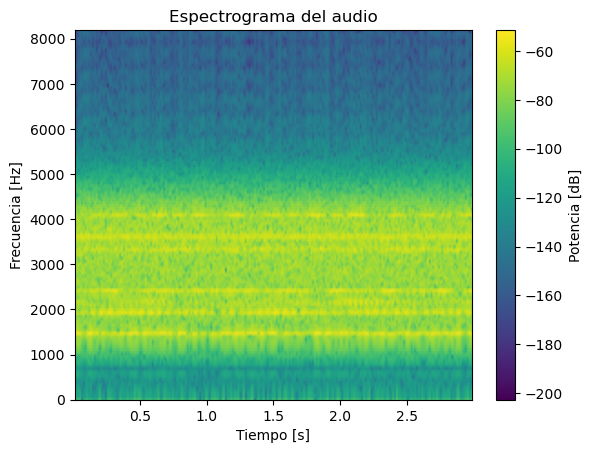

In [19]:
from scipy.signal import spectrogram

# Calcular el espectrograma del audio
f_espectrograma, t_espectrograma, Sxx = spectrogram(segmento_filtrado, fs)

# Graficar el espectrograma
plt.pcolormesh(t_espectrograma, f_espectrograma, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [s]')
plt.title('Espectrograma del audio')
plt.colorbar(label='Potencia [dB]')
plt.show()

# Resampling
Para lograr una mejor definición de la señal, se debe hacer un resampleo. Esto tienen consecuencias por eso debe elegirse bien la frecuencia de tal forma que no se introduzca ruido.

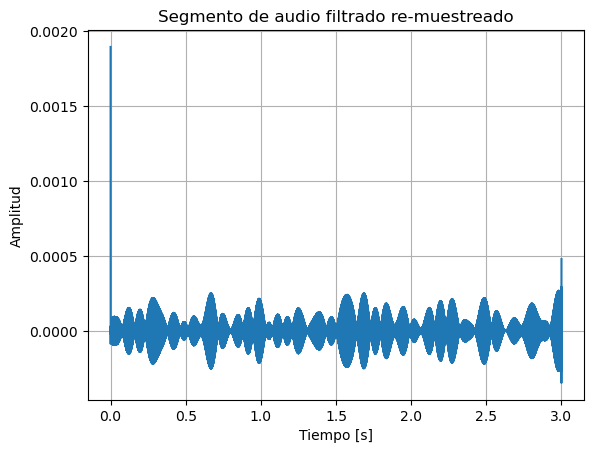

In [21]:
from scipy.signal import resample

# Nueva frecuencia de muestreo deseada
nueva_fs = 2000  

# Realizar el re-muestreo de la señal de audio filtrada
segmento_audio_resampled = resample(segmento_filtrado, int(len(segmento_filtrado) * nueva_fs / fs))

# Graficar el segmento de audio filtrado re-muestreado
t_resampled = np.linspace(0, len(segmento_audio_resampled) / nueva_fs, len(segmento_audio_resampled))
plt.plot(t_resampled, segmento_audio_resampled)
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Segmento de audio filtrado re-muestreado')
plt.grid()
plt.show()

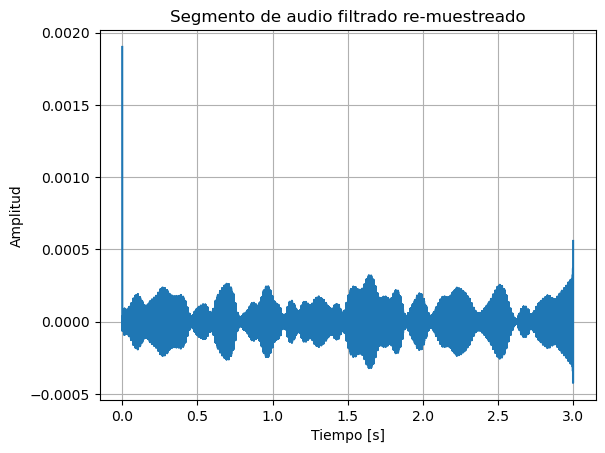

In [55]:
from scipy.signal import resample

# Nueva frecuencia de muestreo deseada
nueva_fs = 2060

# Realizar el re-muestreo de la señal de audio filtrada
segmento_audio_resampled = resample(segmento_filtrado, int(len(segmento_filtrado) * nueva_fs / fs))

# Graficar el segmento de audio filtrado re-muestreado
t_resampled = np.linspace(0, len(segmento_audio_resampled) / nueva_fs, len(segmento_audio_resampled))
plt.plot(t_resampled, segmento_audio_resampled)
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Segmento de audio filtrado re-muestreado')
plt.grid()
plt.show()